In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)
test_model_data = TestingPredictorData[0][6]

In [12]:
from smt.surrogate_models import KPLS
from scipy import stats

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
predictions = []
validations = []
for model_idx in range(len(ModelNames)):
    
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    #MLmodel = PLSRegression(n_components=6)
    sm = KPLS(theta0=[1e-2], n_comp=1)

    # Train model
    TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0], TrainingTargetDataReshaped[:,3]])

    #TrainingTargetDataReshaped = TrainingTargetDataReshaped[:,0]
    all_iter_preds = []
    for x in range(50):
        ensemble_train_indices = random.sample(range(0,len(TrainingPredictorData[model_idx])),100)
        newTrainingPredictorData = np.array(TrainingPredictorData[model_idx])[ensemble_train_indices]
        newTrainingTargetDataReshaped = np.array(TrainingTargetDataReshaped)[ensemble_train_indices]
        sm.set_training_values(newTrainingPredictorData, newTrainingTargetDataReshaped)
        sm.train()

        # Predict using trained model
        iteration_pred = sm.predict_values(np.array(TestingPredictorData[model_idx]))
        all_iter_preds.append(iteration_pred)
    Y_pred = np.nanmean(all_iter_preds, axis=0)

    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    validations.append([TestingTargetDataReshaped[:,0]])
    predictions.append(Y_pred)
    print(ModelNames[model_idx])
    true_vals = [TestingTargetDataReshaped[:,0]]
    #nat_val = true_vals[0]
    for_val = true_vals[0]
    print(stats.pearsonr(for_val, Y_pred.T[0])[0])
    #print(np.nanmean(np.abs((np.array(nat_val) - np.array(Y_pred.T[0])))))
    print(np.nanmean(np.abs((np.array(for_val) - np.array(Y_pred.T[0])))))
    


___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3505092
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 40
   
   Predicting ...
   Predicting - done. Time (sec):  0.1264889
   
   Prediction time/pt. (sec) :  0.0031622
   
___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Trainin

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/smt/surrogate_models/krg_based.py:211: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn("Warning: multiple x input features have the same value (at least same row twice).")


   Training - done. Time (sec):  0.3516219
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.1498132
   
   Prediction time/pt. (sec) :  0.0029963
   
___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3506558
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 50
   
   Predicting ...
   Predicting - done. Time (sec):  0.1484871
   
   Prediction time/pt. (sec) :  0.0029697
   
__________________________________________________________________

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/smt/surrogate_models/krg_based.py:211: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn("Warning: multiple x input features have the same value (at least same row twice).")


   Training - done. Time (sec):  0.3984640
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 32
   
   Predicting ...
   Predicting - done. Time (sec):  0.1119599
   
   Prediction time/pt. (sec) :  0.0034987
   
___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.4647133
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 32
   
   Predicting ...
   Predicting - done. Time (sec):  0.1195676
   
   Prediction time/pt. (sec) :  0.0037365
   
__________________________________________________________________

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/smt/surrogate_models/krg_based.py:211: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn("Warning: multiple x input features have the same value (at least same row twice).")


   Training - done. Time (sec):  0.3767834
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10
   
   Predicting ...
   Predicting - done. Time (sec):  0.0348125
   
   Prediction time/pt. (sec) :  0.0034812
   
___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3678327
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10
   
   Predicting ...
   Predicting - done. Time (sec):  0.0349922
   
   Prediction time/pt. (sec) :  0.0034992
   
__________________________________________________________________

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/smt/surrogate_models/krg_based.py:211: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn("Warning: multiple x input features have the same value (at least same row twice).")


   Training - done. Time (sec):  0.3497131
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10
   
   Predicting ...
   Predicting - done. Time (sec):  0.0349121
   
   Prediction time/pt. (sec) :  0.0034912
   
___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3440247
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10
   
   Predicting ...
   Predicting - done. Time (sec):  0.0352480
   
   Prediction time/pt. (sec) :  0.0035248
   
__________________________________________________________________

In [13]:
# Using 3 components
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.6914853778831779
0.019747298143488457


In [11]:
# Using 3 components
true_values = []
prediction_data = []
for x in range(14):
    for y in range(0, len(validations[x][0].T)):
        true_values.append(validations[x][0].T[y])
        prediction_data.append(predictions[x][y][0])
        
print(stats.pearsonr(true_values, prediction_data)[0])
print(np.nanmean(np.abs((np.array(prediction_data) - np.array(true_values)))))

0.6968490141616986
0.019469063841556472


In [15]:
#natural
gistemp_predictions = np.array(gistemp_predictions)
era5_predictions = np.array(era5_predictions)
hadcrut_predictions = np.array(hadcrut_predictions)
print(np.nanmean(gistemp_predictions[:,0,0]), np.nanmean(era5_predictions[:,0,0]), np.nanmean(hadcrut_predictions[:,0,0]))

-0.07349403113181456 -0.04987738579426813 -0.055126083126221144


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

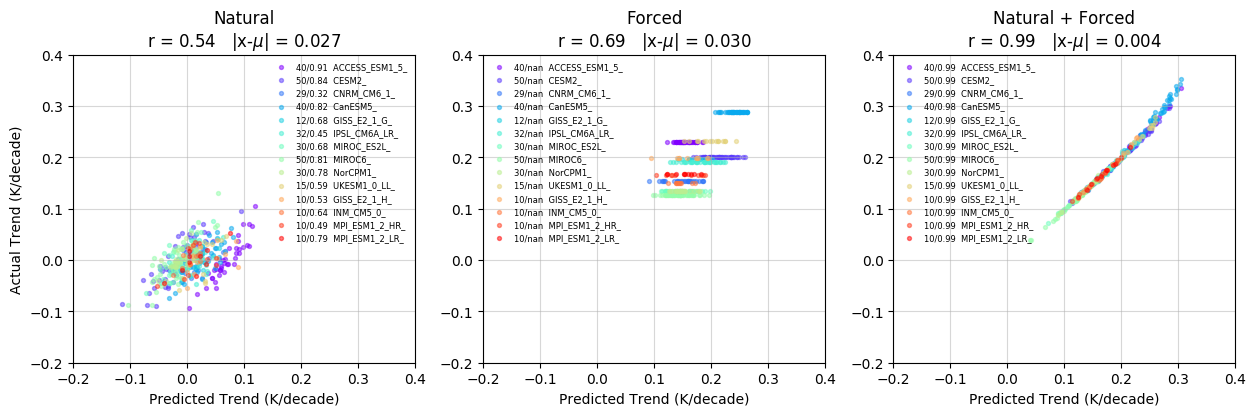

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 14))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,3]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.2,0.4)
        axs_obj.set_xlim(-0.2,0.4)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.abs((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:5])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

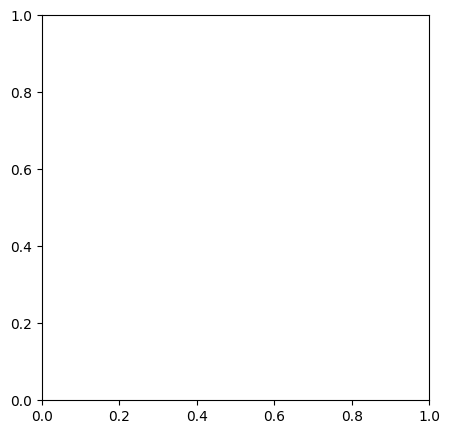

In [9]:
fig, axs_obj = plt.subplots(1, 1, figsize=(5, 5))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 20))
all_r_values = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]
    ValidationData = TestingTotalTrend[model_idx]
    #ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    N_ensembles = len(PredictedData)
    
    r_values = []
    for predictant_idx in range(1):
        #val = ValidationData[:,0]
        val = ValidationData
        pred = PredictedData[:,0] + PredictedData[:,3]
        r = stats.pearsonr(val, pred)[0]
        r_values.append(r)
        
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)

        axs_obj.set_ylim(-1,2)
        axs_obj.set_xlim(-1,2)
        axs_obj.set_ylabel('Trend (K/decade)')
        axs_obj.set_xlabel('Predicted Natural + Predicted Forced Trend (K/decade)')
    all_r_values.append(r_values)
axs_obj.set_title('PLS Regression: r = ' + str(np.nanmean(all_r_values))[:4])


In [7]:
print('Natural: ', np.nanmean(ERA5_predictions, axis=0)[0,0])
print('Forced: ', np.nanmean(ERA5_predictions, axis=0)[0,3])
print('Sum: ', np.nanmean(ERA5_predictions, axis=0)[0,0] + np.nanmean(ERA5_predictions, axis=0)[0,3])

NameError: name 'ERA5_predictions' is not defined

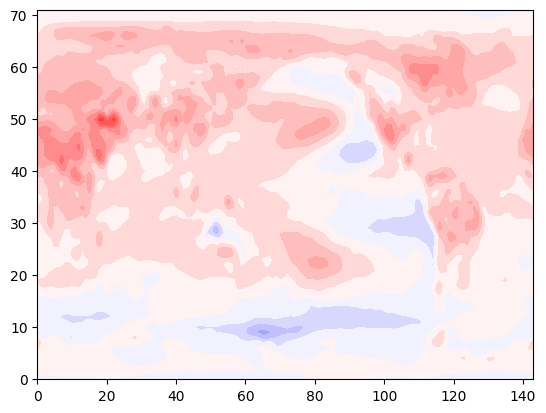

In [5]:
plt.contourf(np.reshape(observational_trend_maps_reshaped[1], (72,144)), cmap='bwr', levels=np.linspace(-1,1,21), extend='both')

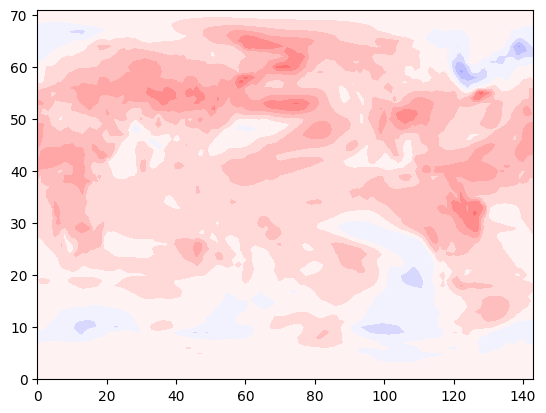

In [6]:
plt.contourf(np.reshape(test_model_data, (72,144)), cmap='bwr', levels=np.linspace(-1,1,21), extend='both')